# Naive Bayes
**Naive Bayes** is one of the most powerful tools statistics has for feature-based prediction, so let's code our own!

First, you should be familiar with the [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)

I personally think [this explanation](https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/) is better 

Now it's time to watch some cool youtube videos explaining [what Naive Bayes is](https://www.youtube.com/watch?v=CPqOCI0ahss)

Go ahead and  watch it a couple of times because it is kind of important

The problem with the author's approach is that it only works with categorized data, say the day was **hot**. But what should we do if we know that the temperature was (say) **24c** and the humidity was **40%**? Let's find out by building our own Bayes classifier that will work with numerical data

We need to load the dataset we are going to work with and see how it looks like

**sample** means the data rows will be shuffled

**reset_index** means there will be no column indicating which position the row used to be at (change to false if you are curious)

In [11]:
import pandas
data = pandas.read_csv("../data/Iris.csv").sample(frac=1).reset_index(drop=True)
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,10,4.9,3.1,1.5,0.1,Iris-setosa
1,114,5.7,2.5,5.0,2.0,Iris-virginica
2,8,5.0,3.4,1.5,0.2,Iris-setosa
3,45,5.1,3.8,1.9,0.4,Iris-setosa
4,106,7.6,3.0,6.6,2.1,Iris-virginica


Let's make our data look cool and split it into the x (features) and y (answers)

It worth mentioning that I am using label encoder for species (just maps the name to a number):

|       Raw      | Label-encoded |
|:--------------:|---------------|
| Iris-setosa    |       0       |
| Iris-virginica |       1       |
| Iris-virginica |       1       |
| Iris-versicolor|       2       |


**Note: if the key error is thrown, the ID field is already deleted. Execute the first block again**

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

del data["Id"] # Id is not a feature

y = data["Species"]
x = data.copy()
y = le.fit_transform(y)
del x["Species"]

x_train = x[:120]
x_test = x[120:]
y_train = y[:120]
y_test = y[120:]

In [13]:
x_train.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,4.9,3.1,1.5,0.1
1,5.7,2.5,5.0,2.0
2,5.0,3.4,1.5,0.2
3,5.1,3.8,1.9,0.4
4,7.6,3.0,6.6,2.1


In [14]:
y_train[:5]

array([0, 2, 0, 0, 2])

Now it's time to calculate **Individual Probabilities**. In order to do so, we need to know some statistics.

Let's look at how the author of the video does it:

He has P(sunny|yes) = 2/9, P(sunny|no) = 3/5. He counted it based on the class counts

What we want to do is to generalize P(feature|class). And how do we calculate it?

Let's assume we have a dataset of people heights. We have two categories: males and females.

<img src="../res/sexism.png" alt="Drawing" style="width: 350px;"/>

What are the odds that a male will have a height equal to 168cm?

Quick note: P(a|x) reads: the probability of a given x is ... 

So, what is the probability of the person's height being 168cm given that he is a male?.

$P(h=168|g=male)$ is a probability of picking a height equal to 168 from male heights  

Easy enough, eh?

But wait? What does 'a probability of picking' mean? We have a dataset of some values that is definitely not a [PDF](https://en.wikipedia.org/wiki/Probability_density_function). How do I measure the probability of picking something from a dataset? 

This is what [z-scores](http://www.statisticshowto.com/probability-and-statistics/z-score/) are used for.

Alright, do we need just to measure the probability using the z score table? Nope. You might be thinking about probability as likelihood but it is not. The probability of picking a height of 168.00000... cm is 0. We also need to know that we always have an observational error. Let's assume it is equal to 0.5 cm. Thus we calculate the probability of picking a height of 168 +- 0.5cm. For more info about likelihood vs probability, I recommend you to check out [this video](https://www.youtube.com/watch?v=pYxNSUDSFH4)

Now that we know how to calculate $P(feature|class)$, we need calculate our probabilities

In [15]:
from math import sqrt, erf, erfc
import numpy as np
from scipy.special import erfinv, erfcinv


class ZTable: 
    # Treat as a black box. Just z table implementation
    # thanks gist.github.com/jarhill0/af251879e57a917a6e2cf8ca27548bbb
    def __init__(self, precision=4):
        self.precision = precision

    def below(self, z_score):
        return round(0.5 + 0.5 * erf(z_score / sqrt(2)), self.precision)

    def above(self, z_score):
        return round(0.5 * erfc(z_score / sqrt(2)), self.precision)

zTable = ZTable()

def zScore(data, value):
    return *code here*


# we need treshold because the probability is able to be 0 since that it might not be included in the dataset
def probabilityOfPicking(data, value, error, threshold=0.0001):
    p = 1 - *code here* - *code here*
    if(p < threshold):
        return threshold
    return p

### Lets look on the probability of picking some SepalLengthCm of (say) 0'st specie.

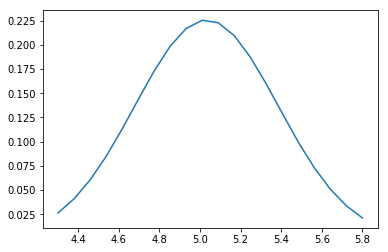

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

SL0 = []
for i in range(y_train.size):
    if y_train[i] == 0:
       SL0.append(x_train['SepalLengthCm'][i]) 
SL0 = np.array(SL0)

ls = np.linspace(SL0.min(), SL0.max(), 20)
probabilities = [probabilityOfPicking(SL0, i, 0.1) for i in ls]
plt.plot(ls, probabilities)
plt.show()

### See that bell looking curve? looks fantastic!
Now lets build  the classifier

In [17]:
# Might be useful for calculating product P(feature|class) * p(class) 
from functools import reduce
import operator

class BayesClassifier:
    
    def __init__(self):
        self.x_train = []
        self.y_train = []
    
    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        
    def predict(self, features, error=0.1): # takes a single array of features, not x_test itself
        # pandas df -> list
        
        features = features.to_dict()
        features = [list(features[i].values())[0] for i in features]
        
        *code here*

In [18]:
bc = BayesClassifier()
bc.fit(x_train, y_train)
bc.predict(x_test.iloc[[0]], 0.1)

2

In [19]:
from sklearn.metrics import accuracy_score

y_pred = [bc.predict(x_test.iloc[[i]],  0.1) for i in range(y_test.size)]
print('accuracy_score:', accuracy_score(y_test, y_pred))

accuracy_score: 0.9333333333333333


(My accuracy score is about 0.95)

### Conclusion:
Yay! It works and the accuracy is pretty decent! The cool thing is that is is not able to overfit! It can also be solved using feedforward nn but we there is no need for using them since that you know what Naive Bayes is.

**What we found out today:**
- Bayes theorem. How to update the probabilities of hypotheses when given evidence.
- Z-scores. How to find the probability of occurrence of some element in the dataset.